In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import math

[6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78]


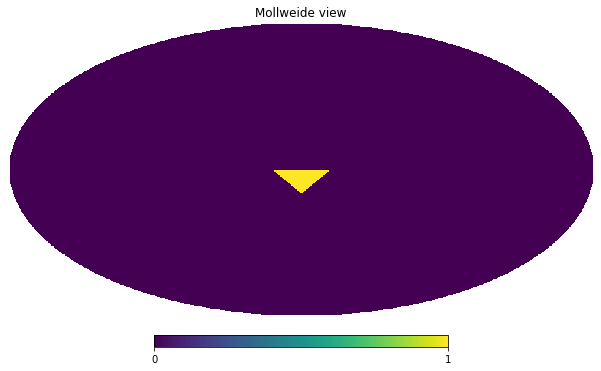

In [3]:
nside = 512
mask = np.zeros(hp.nside2npix(nside))
mask_ = np.zeros(hp.nside2npix(nside))
a = 3
x = a
triangle = hp.query_polygon(nside, [hp.ang2vec(-a,0, lonlat=True), hp.ang2vec(a,0, lonlat=True), hp.ang2vec(0, -2*a/3, lonlat=True)])
mask[triangle] = 1.0
length=[2*a]
for i in range(12):
    x = x + 3
    trang = hp.query_polygon(nside, [hp.ang2vec(-x,0, lonlat=True), hp.ang2vec(x,0, lonlat=True), hp.ang2vec(0, -2*x/3, lonlat=True)])
    mask_[trang] = 1.0
    mask = np.vstack((mask,mask_))  # now mask has shape (11,3145728)
    length.append(2*x)
print(length)
hp.mollview(mask[5])

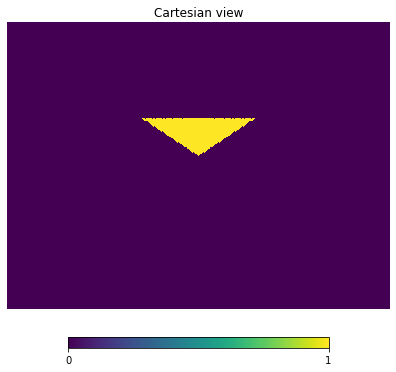

In [49]:
hp.cartview(mask[1], lonra=[-20,20], latra=[-20,10])

In [3]:
ffp10 = hp.read_map("/mnt/c/Users/hp/Downloads/febecop_ffp10_lensed_scl_cmb_353_mc_0000.fits", field=(0, 1, 2))

In [7]:
ffp10 = hp.ud_grade(ffp10, nside_out=nside)

angle = 0.5
LMAX = 200

ffp10 = hp.smoothing(ffp10, fwhm=np.radians(angle))

In [ ]:
hp.cartview(mask[2]*ffp10[0], lonra=[-35, 35], latra=[-25, 10], cmap='RdBu_r', min=-3e-4, max=3e-4)

In [8]:
def tqu2teb(T,Q,U,lmax):
    nside = hp.npix2nside(len(T))
    alms = hp.map2alm([T,Q,U],lmax = lmax, pol=True)
    E = hp.alm2map(alms[1], nside=nside, lmax=lmax)
    B = hp.alm2map(alms[2], nside=nside, lmax=lmax)
    return T,E,B

def tqu2qeueqbub(T, Q, U, lmax, getEfamily=True, getBfamily=True):
    nside = hp.npix2nside(len(T))
    
    alms = hp.map2alm([T, Q, U], lmax=lmax, pol=True)
    alms0 = np.zeros(len(alms[0]), dtype='complex')
    
    if getEfamily:
        Efamily = hp.alm2map([alms[0], alms[1], alms0], nside=nside, lmax=lmax, pol=True)
        QE = Efamily[1]
        UE = Efamily[2]
    if getBfamily:
        Bfamily = hp.alm2map([alms[0], alms0, alms[2]], nside=nside, lmax=lmax, pol=True)
        QB = Bfamily[1]
        UB = Bfamily[2]
        
    if getEfamily and getBfamily:
        return QE, UE, QB, UB
    elif getEfamily:
        return QE, UE
    elif getBfamily:
        return QB, UB

In [9]:
T, E, B = tqu2teb(*ffp10, lmax=LMAX)

In [12]:
maskedT, maskedE, maskedB = tqu2teb(ffp10[0] * mask[0], ffp10[1] * mask[0], ffp10[2] * mask[0], lmax=LMAX)
for i in range(1,13):
    _, _, maskedB_ = tqu2teb(ffp10[0] * mask[i], ffp10[1] * mask[i], ffp10[2] * mask[i], lmax=LMAX)
    maskedB = np.vstack((maskedB,maskedB_))

In [1]:
cmap = plt.cm.get_cmap("jet").copy()
cmap.set_bad(color='white')

plt.figure(figsize=(20, 15))

hp.cartview(B * mask[10], 1, sub=(3,1,1), lonra=[-30, 30], latra=[-25, 10], cmap='RdBu_r', min=-0.5e-6, max=0.5e-6, cbar=False)
plt.title('Real B mode')

hp.cartview(maskedB[10] * mask[10], 1, sub=(3,1,2), lonra=[-30, 30], latra=[-25, 10], cmap='RdBu_r', min=-0.5e-6, max=0.5e-6, cbar=False)
plt.title('Masked B mode')

hp.cartview((maskedB[10] - B) * mask[10], 1, sub=(3,1,3), lonra=[-30, 30], latra=[-25, 10], cmap='RdBu_r', min=-0.5e-6, max=0.5e-6, cbar=False)
plt.title('Error')

NameError: name 'plt' is not defined

In [10]:
def correct_leakage(m, mask):
    QEp, UEp = tqu2qeueqbub(m[0]*mask, m[1]*mask, m[2]*mask, lmax=LMAX, getBfamily=False)
    
    _, _, template = tqu2teb(m[0]*mask, QEp*mask, UEp*mask, lmax=LMAX)
        
    return template * 2   #template is a B mode generated by "pure" QE and UE parameters

In [14]:
template = correct_leakage([*ffp10], mask[0])
for i in range(1,13):
    template_ = correct_leakage([*ffp10],mask[i])
    template = np.vstack((template,template_))

In [ ]:
plt.figure(figsize=(20, 15))

hp.cartview((maskedB[8] - B) * mask[8], 1, sub=(3,1,1), lonra=[-30, 30], latra=[-20, 5], cmap='RdBu_r', min=-0.5e-6, max=0.5e-6, cbar=False)
plt.title('Error')

hp.cartview(template[8]*mask[8], 1, sub=(3,1,2), lonra=[-30, 30], latra=[-20, 5], cmap='RdBu_r', min=-0.5e-6, max=0.5e-6, cbar=False)
plt.title('Template')

hp.cartview((maskedB[8] - B)*mask[8] - template[8]*mask[8], 1, sub=(3,1,3), lonra=[-30, 30], latra=[-20, 5], cmap='RdBu_r', min=-0.5e-6, max=0.5e-6, cbar=False)
plt.title('Residual error')

In [ ]:
########### For rescaling
Error = []
for i in range(13):
    value = np.sqrt(((maskedB[0] - B)[mask[0]==1]**2).mean())
    Error.append(np.sqrt(((maskedB[i] - B)[mask[i]==1]**2).mean())/value)
    
resError = []
for i in range(13):
    value_ = np.sqrt(((maskedB[0] - B - template[0])[mask[0]==1]**2).mean())
    resError.append(np.sqrt(((maskedB[i] - B - template[i])[mask[i]==1]**2).mean())/value_)

In [ ]:
########### For standard plot
Error = []
for i in range(13):
    Error.append(np.sqrt(((maskedB[i] - B)[mask[i]==1]**2).mean()))
    
resError = []
for i in range(13):
    resError.append(np.sqrt(((maskedB[i] - B - template[i])[mask[i]==1]**2).mean()))

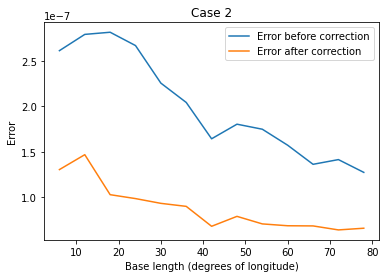

In [17]:
plt.plot(length,Error)
plt.plot(length,resError)
plt.xlabel("Base length (degrees of longitude)")
plt.ylabel("Error")
plt.legend(["Error before correction","Error after correction"])
plt.title("Case 2")
plt.show()

In [50]:
RedError = []
for i in range(13):
    RedError.append(((Error[i]-resError[i])/Error[i])*100)

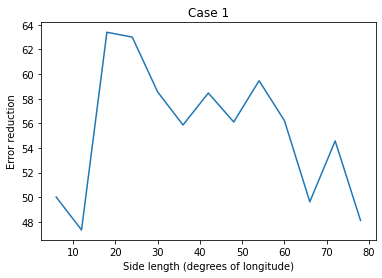

In [51]:
plt.plot(length,RedError)
plt.xlabel("Side length (degrees of longitude)")0,
plt.ylabel("Error reduction")
plt.title("Case 1")
plt.show()

In [ ]:
# CASE 1: Equilateral triangle, side on equator
length1 = [6, 12, 18, 24, 30, 36, 42]  #in degrees of longitude
Error1 = [2.7428812699404206e-07, 2.767091383319328e-07, 2.1929275558387872e-07, 1.9246291979371462e-07, 1.6563707914524155e-07, 1.6300576418493502e-07, 1.411574110801243e-07]
resError1 = [1.3234826385064752e-07, 1.0718400281836047e-07, 9.112936599006183e-08, 7.774753938439289e-08, 7.216956720240772e-08, 6.396580616840165e-08, 5.729128299673773e-08]
RedError1 = [51.7484532410977, 61.26474049086683, 58.44396877250916, 59.603886573203724, 56.42909934488481, 60.75856182862927, 59.41319512850952]